# Week 5 - Linear regression
by Colin Rundel & David Elliott & Kit Searle

1. [Setup](#setup)

2. [Least squares](#RBH)

3. [Regression using scikit-Learn](#RSKL)

4. [Regression with categorical cariables](#SKV)

5. [Least Squares & rank deficiency ](#LSRD)

6. [Multiple linear regression](#mlr)

7. [Model refinement](#refine)

This week we will be implementing the linear regression techniques from this weeks lecture in python.

---

# 1. Setup <a id='setup'></a>

## 1.1. Uploading your data to the colab
This notebook will be saved in your google drive in a folder "Colab Notebooks" by default, you should be fairly familiar with this by now.

When you run this cell you will need to give colab permission to access files in your drive.

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/mlp/week-5')
!ls

MessageError: ignored

We will now unzip the workshop materials and place them in a subdirectory "ws-material/"

In [ ]:
if not os.path.exists('ws-material'):
  print('Unzipping materials...')
  !unzip week-05.zip -d ws-material
else:
  print("Directory already exists!")

os.chdir('ws-material')
!ls

Directory already exists!
Data  Images  scripts


__Reminder__ 

- You may need to restart the runtime several times in the workshop, but you will not need to re-upload or unzip files again. 

## 1.3. Packages

Now lets load in the packages you wil need for this workshop.

In [ ]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold


###  Helper Functions

Below are two helper functions we will be using in this workshop.

In [ ]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

## 1.4 Data

To begin, we will examine a simple data set on the size and weight of a number of books. These data come from the `Medical Cost Personal` data set. Our goal is to model the yearly medical charges of an individual using some combination of the other features in the data. The included columns are as follows:

* `charges` - yearly medical charges in USD
* `age` - the individuals age
* `sex` - the individuals sex, either `"male"` or `"female"`
* `bmi` - the body mass index of the individual
* `children` - the number of dependent children the individual has
* `smoker` - a factor with levels `"yes"`, the individual is a smoker and `"no"`, the individual is not a smoker

We read the data into python using pandas.


In [ ]:
df_insurance = pd.read_csv("./Data/insurance.csv")
df_insurance[:5]

,age,sex,bmi,children,smoker,charges
0,19,female,27.900,0,yes,16884.92400
1,18,male,33.770,1,no,1725.55230
2,28,male,33.000,3,no,4449.46200
3,33,male,22.705,0,no,21984.47061
4,32,male,28.880,0,no,3866.85520


We will begin by constructing a pairs plot of our data and examining the relationships between our variables.

---

### 🚩 Exercise 1

Create a pairs plot of these data (make sure to include the `smoker` column), describe any relationships you observe in the data.

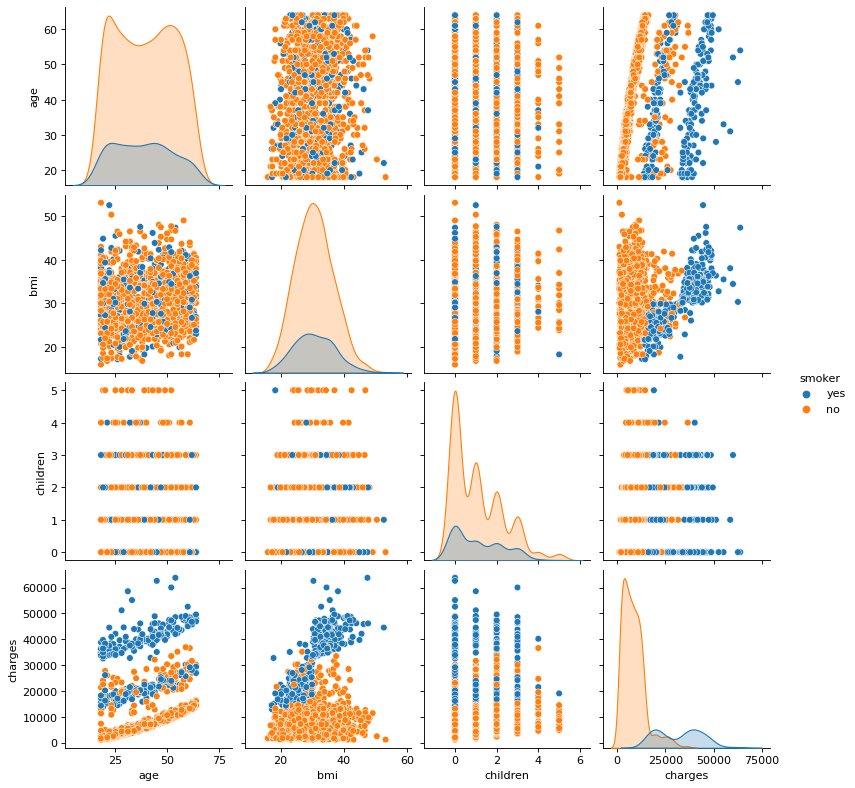

In [ ]:
sns.pairplot(data = df_insurance, hue = "smoker")

---

Solution

`bmi` and `chrges` as well `age` and `charges` asapear to exibit linear relationships. There is a distinct difference in the `charges` between smokers and non smokers.


### 1.4.1 Test Set
We will split our data into two distinct sets. The first called the `training set` will contain our test data `X_train` and `y_train` which is used for determining the feature weights. The second called the `test set` will contain our testing data `X_test` and `y_test`

In [ ]:
from sklearn.model_selection import train_test_split
X = df_insurance.drop('charges',axis=1) # Independet variable
y = df_insurance['charges'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)


# 2. Least Squares  <a id='RBH'></a>

We will begin by fitting a simple linear regression model for `charges` exclusively using `bmi` as a feature in our model. 

---

### 🚩 Exercise 2

Create a scatter plot using the `insurance_df` data frame describe any apparent relationship between `charges` and `bmi` (make sure to include the smoker `column`).

Hint: You can use the input hue ="something" 

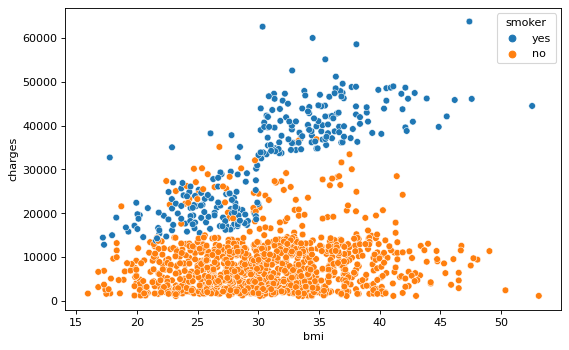

In [ ]:
sns.scatterplot(x="bmi", y="charges", hue="smoker", data=df_insurance)

In lecture we discussed how we can represent a regression problem using matrix notation and we can derive a solution using least squares. We can express this as,

$$
\underset{\boldsymbol{\beta}}{\text{argmin}} \,\, \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2 
= \underset{\boldsymbol{\beta}}{\text{argmin}} \,\, (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta})^\top(\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta})
$$

where,

$$
\underset{n \times 1}{\boldsymbol{y}} = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_{n-1} \\ y_n \end{pmatrix} 
\qquad
\underset{n \times 2}{\boldsymbol{X}} = \begin{pmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_{n-1} \\ 1 & x_n \\ \end{pmatrix}
\qquad 
\underset{2 \times 1}{\boldsymbol{\beta}} = \begin{pmatrix} \beta_0 \\ \beta_1 \end{pmatrix}
$$

The solution to this optimization problem is,

$$
\boldsymbol{\beta} = \left(\boldsymbol{X}^\top\boldsymbol{X}\right)^{-1} \boldsymbol{X}^\top\boldsymbol{y}
$$

In Python we can construct the model matrix `X` by combining a column of ones, for the intercept, with our observed `bmi` values. Similarly, `y` is a column vector of the `charges` values. In both cases we construct these objects as numpy array objects.

In [ ]:
y = np.array(y_train)
print(y[:5])

[ 4320.41085  8347.1643   1984.4533  12957.118   36189.1017 ]


In [ ]:
X = np.c_[
    np.ones(len(y_train)),
    X_train.bmi
]

print(X[:5])

[[ 1.    35.815]
 [ 1.    38.17 ]
 [ 1.    40.47 ]
 [ 1.    21.4  ]
 [ 1.    31.73 ]]


Given the model matrix $(\boldsymbol{X})$ and observed outcomes $(\boldsymbol{y})$ we can then calculate the vector of solutions $(\boldsymbol{\beta})$ using numpy,

In [ ]:
from numpy.linalg import solve
beta = solve(X.T @ X, X.T @ y)
print(beta)

[656.92756808 418.82302133]


Note that when using numpy `@` performs  matrix multiplication while `*` performs elementwise multiplication between arrays. Numpy matrix multiplication can also be written using `A.dot(B)` or `np.matmul(A,B)`.

We can calculate predictions from this model by calculating $\hat{y} = \boldsymbol{X} \boldsymbol{\beta}$. 

---

### 🚩 Exercise 3

Calculate these predicted charges and store them in the origin `X_train` data frame in a column called `charges_pred`. Print out the updated version of the data frame with this new column added.

In [ ]:
X_train["charges_pred"] = X @ beta
X_train[:5]

---

Given the predictions we can create a plot showing the models fit by overlaying a line plot of the predictions on top of the original scatter plot.

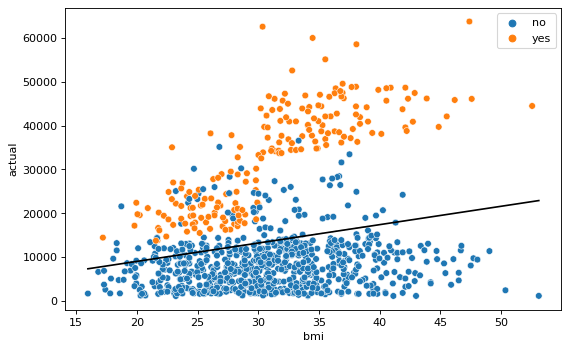

In [ ]:
X_train["actual"] = y_train
sns.scatterplot(x="bmi", y="actual",hue = "smoker", data=X_train)
sns.lineplot(x="bmi", y="charges_pred", color="black", data=X_train)

## 2.1 Residuals

From the figure above, do you think that this model is a good fit? 

One of the most useful tools for evaluating a model is to examine the residuals of that model. For any standard regression model the residual for observation $i$ is defined as $y_i - \hat{y}_i$ where $\hat{y}_i$ is the model's predicted value for observation $i$. As mentioned previous, for the case of linear regression
$\hat{y} = \boldsymbol{X} \boldsymbol{\beta}$.

---

### 🚩 Exercise 4

Calculate the residual for each observation and store them in the origin `X_train` data frame in a column called named `resid`. Using this new column create a residual plot (scatter plot of volume vs resid) for this model. Color the points based on weather the individual is a smoker or not.

Hint: You can either use `y_train` or use the collumn `actual` in `X_train`

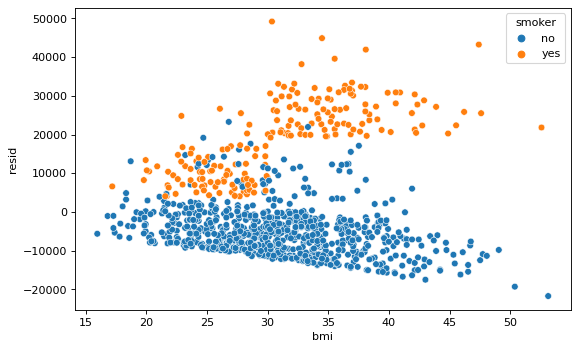

In [ ]:
X_train["resid"] = X_train.actual - X_train.charges_pred
sns.scatterplot(x="bmi", y="resid", hue="smoker", data=X_train)

What do you notice about this plot? Hold that thought, we will get back to this later.

The $R^2$ (also called the coefficient of determination) statistic provides an alternative measure of evaluating the usefullness of the model. It takes the form of a proportion, the proportion of variance explained by the independent variable. To calculate the $R^2$ we use the formula $$R^2 = 1- \frac{RSS}{TSS},$$ where $$RSS = \sum_{i=1}^{N}(y_i -\hat{y}_i)^2$$ is called the residual sum of squares, $$TSS = \sum_{i=1}^{N}(y_i -\overline{y})^2$$ is called the total sum of squares and $\overline{y}$ is the sample mean.

---

### 🚩 Exercise 5

Calculate the $R^2$ score for this model and comment on the value which you obtain.

In [ ]:
mean = sum(X_train.actual)/len(X_train)
R_square = 1 - sum(np.square(X_train.resid))/sum(np.square(X_train.actual - mean))
R_square

0.04479238341244385

This is not a good $R^2$ value. The model does not explain much variability of the dependent variabke around its mean. 

---
# 3 Regression using scikit-Learn <a id='RSKL'></a>

Constructing the model matrix by hand and calculating $\boldsymbol{\beta}$ and model predictions using the least squares solution is less than ideal. As you might expect there are a number of higher level libraries that take care of many of these details. In this course we will be using the **scikit-learn** (**sklearn**) library to implement most of our machine learning models. As the semester progresses we will be learning about and implementing many different modeling methods. Additionally, we will also be learning how to use the larger data processing and workflow tools that are available in this library.

sklearn separates its various modeling tools into submodules organized by model type - for today we will be using the `LinearRegression` model from the `linear_model` submodule. Which we can import as follows,

In [ ]:
from sklearn.linear_model import LinearRegression

In general sklearn's models are implemented by first creating a model object, which is configured via constructor arguments, and then using that object to fit your data. As such, we will now create a linear regression model object `lr` and use it to fit our data. Once this object is created we use the `fit` method to obtain a model object fitted to our data. 

In [ ]:
lr = LinearRegression()
l = lr.fit(
    # X must be a matrix so we need to reshape the column
    X = np.array(X_train.bmi).reshape(-1,1), 
    y = y_train
)

This model object then has various useful methods and attributes, including `intercept_` and `coef_` which contain our estimates for $\boldsymbol{\beta}$.

In [ ]:
b0 = l.intercept_
b1 = l.coef_[0]   # Subsetting here returns a scalar value
beta = (b0, b1)

print(beta)

(656.9275680825376, 418.8230213319861)


Using this default construction of `LinearRegression`, sklearn assumes that we have not included an intercept column (ones) in our model matrix and takes care of this for you. Additionally, since the intercept column is added the $\beta$ estimated for this particular column is stored separately, in the `intercept_` attribue.

I generally find this default behavior to be somewhat frustrating to work with, instead my preference is to handle all of the details of constructing the model matrix `X` myself and retrieving all `beta` values (including the intercept) from `coef_` directly. For example, if we use the `X` and `y` variables we defined for the least squares example above and construct the `LinearRegression` object using `fit_intercept=False` then,

In [ ]:
l = LinearRegression(fit_intercept=False).fit(X = X, y = y)
beta = l.coef_
print(beta)


[656.92756808 418.82302133]


Note that this is the same answers we obtained above.

The model fit objects also provide additional useful methods for evaluating the model $R^2$ (`score`) and calculating predictions (`predict`). Using the later we can add another column of predictions to our data frame.

In [ ]:
X_train["charges_skl_pred"] = l.predict(X)
l.score(X,y)

0.04479238341244496

---

### 🚩 Exercise *6*

Do these results agree with the results we obtained when using the numpy least squares method?

Yes they do.

---

## 4. Regression with categorical cariables <a id='RCV'></a>

At the end of exersise 2, you should have noticed that most of the smokers had a positive residual while the non smokers have a negative residule. Based on these results, it should be clear that it is important that our model include information about whether or not the individual is a smoker or not. As such, we need a way of encoding this information into our modeling framework. To do this we need a way of converting our string / categorical variable into a numeric representation that can be included in our model matrix.


### 4.1 Dummy Coding


The most common approach for doing this is called dummy coding, in the case of a binary categorical variable it involves picking one of the two levels of the categorical variable and encoding it as 1 and the other level as 0. With Python we can accomplish this by comparing our categorical vector to the value of our choice and then casting (converting) the result to an integer type.

For example if we wanted to code `smoker` as 1 and `nonsmoker` as 0 we would do the following,

In [ ]:
X_train["smoker_yes"] = (X_train.smoker == "yes").astype(int) # Returns either 0 or 1
X_train[:5]

,age,sex,bmi,children,smoker,actual,charges_pred,resid,charges_skl_pred,smoker_yes
923,34,male,35.815,0,no,4320.41085,15657.074077,-11336.663227,15657.074077,0
1121,46,male,38.170,2,no,8347.16430,16643.402292,-8296.237992,16643.402292,0
713,20,male,40.470,0,no,1984.45330,17606.695241,-15622.241941,17606.695241,0
552,62,male,21.400,0,no,12957.11800,9619.740225,3337.377775,9619.740225,0
738,23,male,31.730,3,yes,36189.10170,13946.182035,22242.919665,13946.182035,1


This is equivalent to using an indicator function in mathematical notation,

$$ 
\mathbb{1}_{s_i} = 
\begin{cases}
1 & \text {if individual $i$ is a smoker} \\
0 & \text {if individual $i$ is not a smoker}
\end{cases}
$$

Alternatively, we can defined the opposite of this where we code `smoker` as 0 and `nonsmoker` as 1,


In [ ]:
X_train["smoker_no"] = (X_train.smoker == "no").astype(int) # Returns either 0 or 1
X_train[:5]

,age,sex,bmi,children,smoker,actual,charges_pred,resid,charges_skl_pred,smoker_yes,smoker_no
923,34,male,35.815,0,no,4320.41085,15657.074077,-11336.663227,15657.074077,0,1
1121,46,male,38.170,2,no,8347.16430,16643.402292,-8296.237992,16643.402292,0,1
713,20,male,40.470,0,no,1984.45330,17606.695241,-15622.241941,17606.695241,0,1
552,62,male,21.400,0,no,12957.11800,9619.740225,3337.377775,9619.740225,0,1
738,23,male,31.730,3,yes,36189.10170,13946.182035,22242.919665,13946.182035,1,0


Now that we have recoded our categorical variable, `smoker`, into a numerical variable we can fit a standard regression model with the form,

$$ y_i = \beta_0 + \beta_1 \, x_i + \beta_2 \, \mathbb{1}_{s_i} $$

which we can represent in matrix form using, $\boldsymbol{y} = \boldsymbol{X} \boldsymbol{\beta}$
where $\boldsymbol{X} = \big[ \boldsymbol{1},\, \boldsymbol{x},\, \boldsymbol{\mathbb{1}_{s}} \big]$.

Using Python, we can use the concatenate function with our 1s column, the `bmi` column, and our new dummy coded indicator column, `smoker_yes`,

In [ ]:
X = np.c_[np.ones(len(y_train)), 
          X_train.bmi, 
          X_train.smoker_yes]
l = LinearRegression(fit_intercept=False).fit(X, y_train)

beta = l.coef_

print(beta)

[-3622.02084713   393.7053145  24026.44829524]


This gives us a regression equation of the form,

$$ 
y_i = -3622.02 + 393.71 \, x_i + 24026.45 \, \mathbb{1}_{s_i} 
$$

which can be rewritten as two separate line equations (one for each case of `smoker`),

$$
y_i = \begin{cases}
        -3622.02 + 393.71 \, x_i & \text{if individual $i$ is a not smoker} \\
        (-3622.02 + 24026.45) + 393.71 \, x_i & \text{if individual $i$ is a smoker.} \\
       \end{cases}
$$

We can calculate prediction points along those lines using the following Python code in which we hard code the possible values of $\boldsymbol{\mathbb{1}_{s_i}}$

In [ ]:
X_train["charges_smoker_pred"] = l.predict(X)

and we can then plot both of these lines along with the observed data.

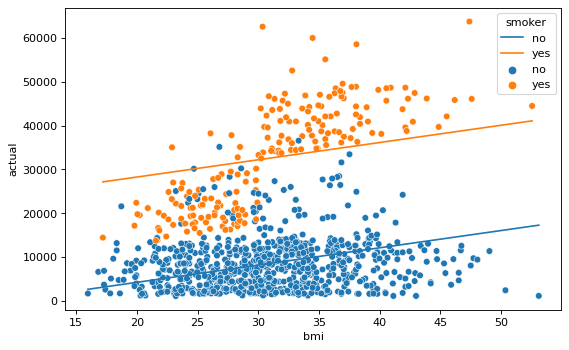

In [ ]:
sns.scatterplot(x="bmi", y="actual", hue="smoker", data=X_train)
sns.lineplot(x="bmi", y="charges_smoker_pred", hue="smoker", data=X_train)

As well as create plot a residual plot of this new model,

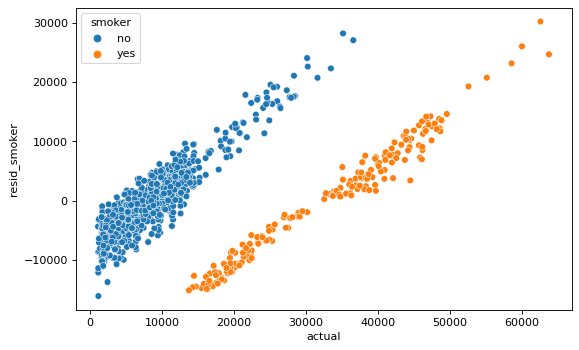

In [ ]:
X_train["resid_smoker"] = X_train.actual - X_train.charges_smoker_pred
sns.scatterplot(x="actual", y="resid_smoker", hue="smoker", data=X_train)

---

### 🚩 Exercise 7

Based on these regression fits, do you think the model including the dummy coded `smoker` variable produces a "better" model than our first regression model which did not include `smoker`? Explain. 

Yes

---

Note that by including a dummy variable in our model will change the interpretation of our regression coefficients. In this context,

* $\beta_0$ - This is the expected charges for in individual with a `bmi` of zero and a `smoker` indicator of zero, in other words a nonsmoker with zero bmi.

* $\beta_1$ - This is the expected additional charges an individual would incure if their bmi were to increase by 1 unit, all else being equal.

* $\beta_2$ - This is the expected additional charges an individual would incure if their indicator were to increase by 1, all else being equal. However, the smoker indicator can only be 0 or 1 and hence this is the change in charges we would expect between a smoker and a nonsmoker with the same bmi. In other words, smokers should expect to pay $24026 more for healthcare than nonsmokers.

Based on these interpretations we can see that the level that was coded as 0 (what is often called the reference level) gets folded into our intercept and the slope coefficient for the indicator provides the difference in intercept between the reference and the contrast level (level coded as 1).


---

### 4.2 One hot encoding

Another common approach for transforming categorical variables is know as one hot encoding, in which all levels of the categorical variable are transformed into a new columns with values of 0 or 1. This is equivalent to what we have done manually above by including both `smoker_yes` and `smoker_no`. This differs from dummy coding in that there is no longer a reference factor.

Pandas has a built-in method for performing this on categorical columns. This is easiest to see with a simple example, below we construct a data frame `df` with a single column that we transform into a one hot encoded version using panda's `get_dummies` method.

In [ ]:
X_train_dummy = pd.get_dummies(X_train[["bmi", "smoker"]], columns=["smoker"])
X_train_dummy[:5]

,bmi,smoker_no,smoker_yes
923,35.815,1,0
1121,38.170,1,0
713,40.470,1,0
552,21.400,1,0
738,31.730,0,1


Note that `get_dummies` does not modify the underlying dataframe in place, and that it is necessary to save the result to a new variable (or overwrite the old version).

---

# 5 Least Squares & rank deficiency <a id='LSRD'></a>

Now lets consider the model where we naively include both `smoker_yes` and `smoker_no` as well as an intercept column in our model matrix.

In [ ]:
X = np.c_[
    np.ones(len(y_train)), 
    X_train.bmi, 
    X_train.smoker_yes,
    X_train.smoker_no
]
l = LinearRegression(fit_intercept=False).fit(X, y_train)


beta = l.coef_
print( beta )

[ 5594.13553366   393.7053145  14810.29191445 -9216.15638079]


This gives us a regression equation of the form,

$$
y_i = \begin{cases}
        5594.14 + 393.71 \, x_i + 14810.29(0) - 9216.16(1) \\= -3622.02 + 393.71 \, x_i & \text{if individual $i$ is not a smoker} \\
        5594.14 + 393.71 \, x_i + 14810.29(1) - 9216.16(0) \\= 20407.43 + 0.6 \, x_i & \text{if individual $i$ is a smoker.} \\
       \end{cases}
$$

However, the solutions ($\boldsymbol{\beta}$) are not unique, anything of the form $\beta_0 + \beta_2 = a$ and $\beta_0 + \beta_3 = b$ will work. In other words we have colinearity between our predictors - if you examine the data it should be clear that given any two of the intercept, `svi_0`, and `svi_1` it is possible to exactly determine the value of the other column. Mathematically, we describe this as these columns are linearly depenedent, which implies that our model matrix is *rank deficient*. You can check this explicitly by via the `numpy.linalg.matrix_rank` function which will report that `X` (and $\boldsymbol{X}^\top\boldsymbol{X}$) are of rank 3 not 4 which is what we might have naievely expected.

This is important as the underlying linear algrebra methods used to solve for $\beta$ for a least squares problem often implicitly assume that $\boldsymbol{X}^\top\boldsymbol{X}$ is full rank in order to solve the matrix inverse and violating these assumptions can have unexpected results.


---

# 6 Multiple linear regression <a id='MLR'></a>

Now we understand the basics of the linear regression, lets fit a baseline model with all the features to use as a point of comparison for our subsequent models.

In [ ]:
full_dummies = pd.get_dummies(df_insurance[["charges","bmi", "age", "children","smoker", "sex"]], columns=["sex", "smoker"])

X = full_dummies.drop('charges',axis=1) # Independet variables
y = full_dummies['charges'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)

X = np.c_[X_train.bmi, 
          X_train.age,
          X_train.children,
          X_train.sex_female,
          X_train.smoker_yes
          ]

lm = LinearRegression().fit(X, y_train)
beta = get_coefs(lm)
print(beta)

[-12325.46741474    334.11762484    247.08434657    532.90066798
    206.55216134  24263.87678352]


These coefficients have the typical regression interpretation, e.g. for each unit increase in `bmi` we expect the `charges` to increase by 334.12 on average. These values are not of particular interest for us for this particular problem as we are more interested in the predictive properties of our model(s). 

Note that in this instance we have not created the intercept column but rather allowed sklearn to handle this.

To evaluate this we will use the model_fit helper function defined above.


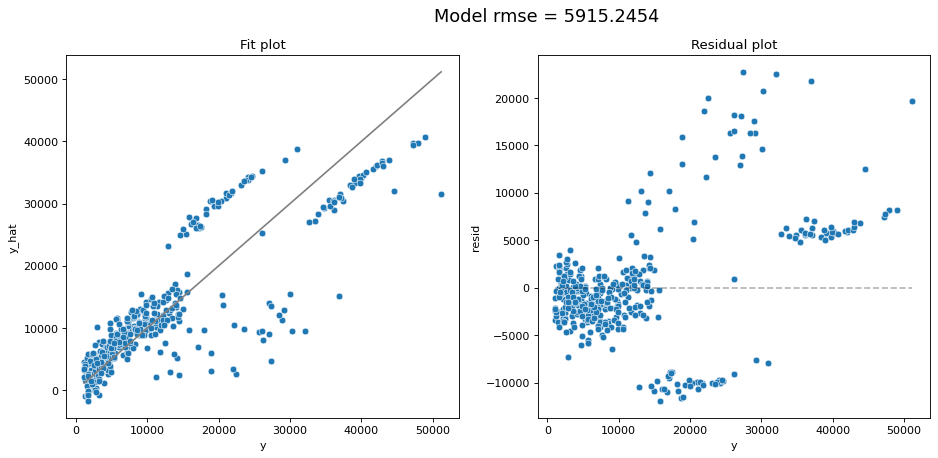

In [ ]:
X_test_matrix = np.c_[X_test.bmi, 
          X_test.age,
          X_test.children,
          X_test.sex_female,
          X_test.smoker_yes
          ]

model_fit(lm, X_test_matrix, y_test, plot=True);

Primarily we will use this function to obtain the rmse of our model using the test data (`X_test` and `y_test`). Note that we fit the model using the training data (`X_train` and `y_train`). We have also included a fit ($y$ vs $\hat{y}$) and resid ($y$ vs $y-\hat{y}$) plot of these results.

---

### 🚩 Exercise 8

Would you expect the rmse of the model to be better or worse when using the training data (compared to the validation data)? Check your answer using the `model_fit` function.

In [ ]:
model_fit(lm, X, y_train)

6122.903618051545

Generally, the validation data should have a worse rmse than the training data since fitting the least squares estimate is 
equivalent to minimizing the rmse. The training fit has a better rmse than our validation fit based on the results
above.

---

### 5.1 Standardization

In subsequent sections we will be exploring the use of the Ridge and Lasso regression models which both penalize larger values of $\boldsymbol{\beta}$. While not particularly bad, our baseline model had $\boldsymbol{\beta}$s that ranged from the smallest at -12325 to the largest at 24263.87678352 which is about a 2x difference in magnitude.

To deal with this issue, the standard approach is to center and scale *all* features to a common scale before fitting one of these models. The typical scaling approach is to subtract the mean of each feature and then divide by its standard deviation - this results in all feature columns having a mean of 0 and a variance of 1. Additionally, the feature values can now be interpreted as the number of standard deviations each observation is away from that column's mean.

Using sklearn we can perform this transformation using the `StandardScaler` transformer from the `preprocessing` submodule.

In [ ]:
from sklearn.preprocessing import StandardScaler
S = StandardScaler().fit(full_dummies.drop(['charges',"sex_male", "smoker_no"], axis=1))

Once fit, we can examine the values used for the scaling by checking the mean_ and var_ attributes of the transformer.

In [ ]:
S.mean_

array([30.66339686, 39.20702541,  1.09491779,  0.49476831,  0.20478326])

In [ ]:
S.var_

array([3.71600900e+01, 1.97253852e+02, 1.45212664e+00, 2.49972629e-01,
       1.62847076e-01])

Keep in mind, that the training, testing, and validation sets will not necessarily have the same feature column means and standard deviations - as such it is important that we choose a consistent set of values that are used for all of the data. In other words, be careful to not expect that StandardScaler().fit_transform(X_train) and StandardScaler().fit(X).transform(X_train) will give the same answer. The best way to avoid this issue is to include the StandardScaler in a modeling pipeline for your data.

In [ ]:
lm_scaled = make_pipeline(
    StandardScaler(),
    LinearRegression()
).fit(X, y_train)


get_coefs(lm_scaled)

array([13627.95708162,  2088.61703718,  3502.47793481,   647.91401284,
         103.24754925,  9890.98801034])

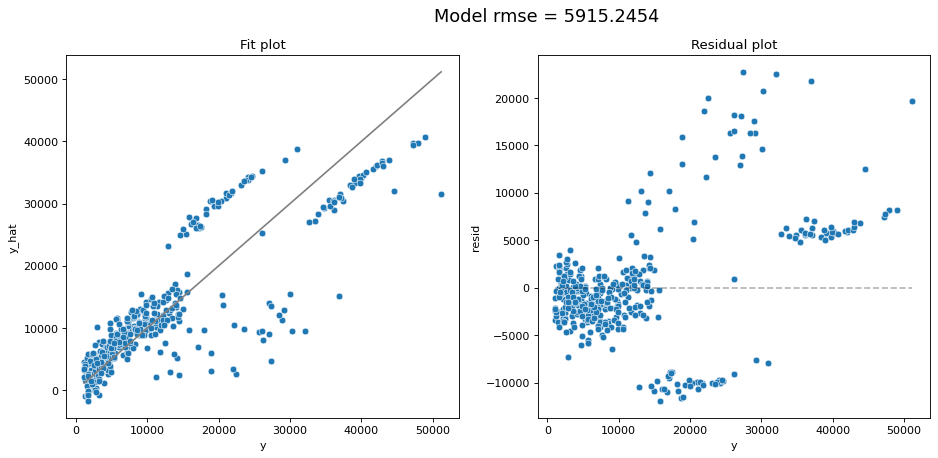

In [ ]:
model_fit(lm_scaled, X_test_matrix, y_test, plot=True);

---

### 🚩 Exercise 9

Using this new model what has changed about our model results? Comment on both the model's coefficients as well as its predictive performance.

Rescaling the features causes the  $\boldsymbol{\beta}$s to change but the model is effectively the same and has the 
same predictive performance as the previous model.

--- 

## 5.2 Ridge Regression

Ridge regression is a natural extension to linear regression which introduces an $\ell_2$ penalty on the coefficients to a standard least squares problem. Mathematically, we can express this as the following optimization problem,

$$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2_2 + \alpha (\boldsymbol{\beta}^T\boldsymbol{\beta}) $$ 

The `Ridge` model is provided by the `linear_model` submodule and requires a single parameter `alpha` which determines the tuning parameter that adjusts the weight of the $\ell_2$ penalty.

[13627.95708162  2055.27058293  3429.16478389   635.0676866
    84.29082217  9681.42788869]


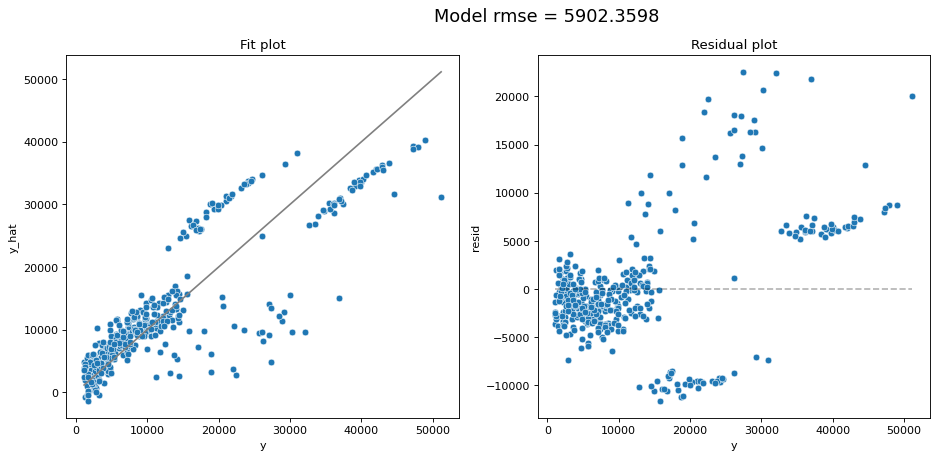

In [ ]:
from sklearn.linear_model import Ridge
r = make_pipeline(
    StandardScaler(),
    Ridge(alpha=20)
).fit(X, y_train)
print(get_coefs(r))

model_fit(r, X_test_matrix, y_test, plot=True);

---

### 🚩 Exercise 10

Adjust the value of alpha in the cell above and rerun it. Qualitatively, how does the model fit change as alpha changes? How does the rmse change?

Model fit does not change much but rmse improves as alpha is increased until around  $\alpha = 200$ 

---

### 🚩 Exercise 11

In Section 5.4 we mentioned the importance of scaling features before fitting a Ridge regression model. The code below fits the Ridge model to the untransformed training data - repeat Exercise 10 using these data. How does the model fit change as alpha changes? How does the rmse change? How does the models performance compare to the previous model?

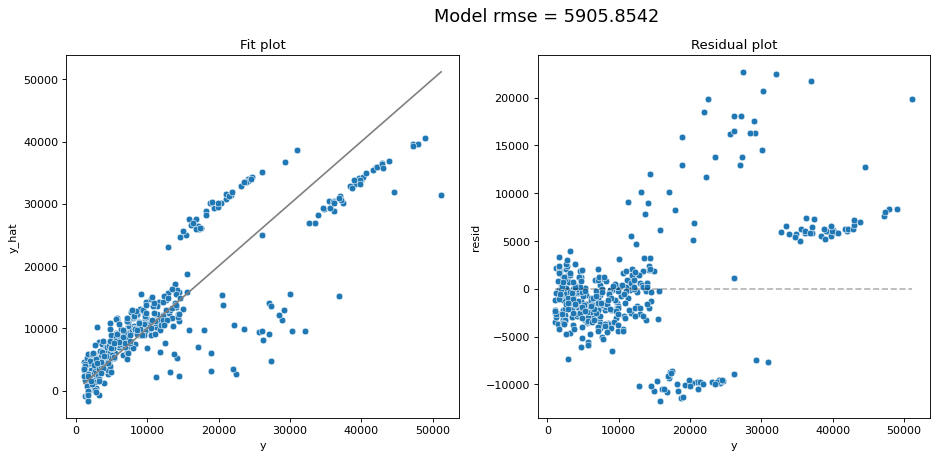

In [ ]:
r_wo_scale = make_pipeline(
    Ridge(alpha=1.6161616161616161)
).fit(X, y_train)

model_fit(r_wo_scale, X_test_matrix, y_test, plot=True);

The fit is roughly equivalent and does not change significantly, rmse improves only slightly with small increases of $\alpha$,
the performance is worse than performance of the previous model.

---

### 5.2.1. Ridge $\beta$s as a function of $\alpha$
 
Finally, one of the useful ways of thinking about the behavior of Ridge regression models is to examine the relationship between our choice of $\alpha$ and the resulting $\beta$s relative to the results we would have obtained from the linear regression model. Since Ridge regression is equivalent to linear regression when $\alpha=0$ we can see that as we increase the value of $\alpha$ we are shrinking all of the $\beta$s towards 0 asymptotically.

In [ ]:
alphas = np.logspace(-2, 3, num=200) # from 10^-2 to 10^3

betas = [] # Store coefficients
rmses = [] # Store validation rmses

for a in alphas:
    m = make_pipeline(
        StandardScaler(),
        Ridge(alpha=a)
    ).fit(X, y_train)
    
    betas.append((get_coefs(m)[1:]))
    rmses.append(model_fit(m, X_test_matrix, y_test))

#plt.plot(alphas,rmses)
#plt.xlabel("alpha")
#plt.ylabel("rmse")

In [ ]:
res = pd.DataFrame(
    data = betas,
    columns = full_dummies.drop(['charges','smoker_no', 'sex_male'],axis=1).columns, # Label columns w/ feature names
).assign(
    alpha = alphas,
    rmse = rmses
).melt(
    id_vars = ('alpha', 'rmse')
)

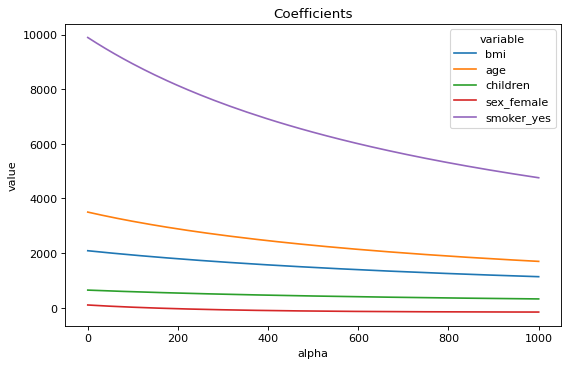

In [ ]:
sns.lineplot(x='alpha', y='value', hue='variable', data=res).set_title("Coefficients")
plt.show()

---

### 🚩 Exercise 12

Based on this plot, which variable(s) seem to be the most important for predicting `charges`.

Hint: think about what the degree of shrinkage towards 0 means in this context.

It appears as if `smoker_yes` has the most amount of shrinkage and therefore is the most important variable in the model, on the other hand `sex_female` has the least shrinkage and is therefore the least important variable.

---

## 5.3. The Lasso

The Lasso is a related modeling approach to Ridge regression, but instead uses an $\ell_1$ penalty on the coefficients. Mathematically, we can express this model as the solution of the following optimization problem,

$$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert_2^2 + \alpha \lVert \boldsymbol{\beta} \rVert_1. $$

As with the other models from this worksheet, the `Lasso` model is also provided by the `linear_model` submodule and similarly requires the choice of the tuning parameter `alpha` to determine the weight of the $\ell_1$ penalty

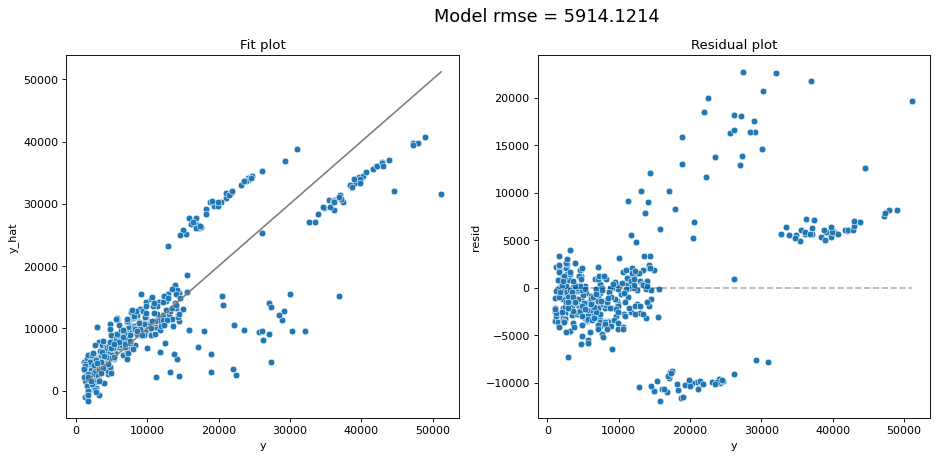

lasso coefs: [13627.95708162  2079.53350536  3493.79018285   638.20017642
    92.02592758  9879.90479089]


In [ ]:
from sklearn.linear_model import Lasso
l = make_pipeline(
    StandardScaler(),
    Lasso(alpha=10)
).fit(X, y_train)
model_fit(l, X_test_matrix, y_test, plot=True);
print("lasso coefs:", get_coefs(l))

---

### 🚩 Exercise 13

Adjust the value of alpha in the cell above and rerun it. Qualitatively, how does the model fit change as alpha changes? How does the rmse change?

The rmse apears to improve until $\alpha = 200$ afterwhith the rmse begins to deteriate.

### 5.3.1. Lasso $\beta$s as a function of $\alpha$

As with Ridge regression we can examine the values of $\beta$ we obtain as tuning parameter $\alpha$ is adjusted. 

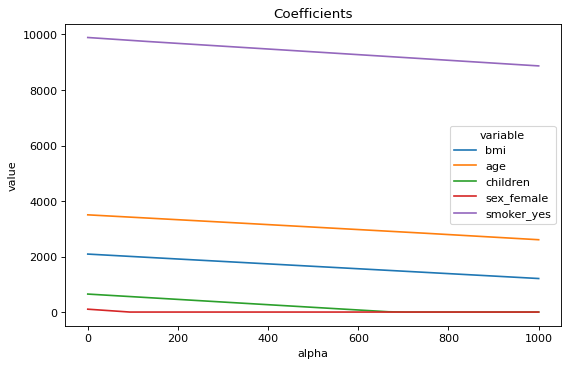

In [ ]:
alphas = np.logspace(-2, 3, num=200)
betas = [] # Store coefficients
rmses = [] # Store validation rmses

for a in alphas:
    m = make_pipeline(
        StandardScaler(),
        Lasso(alpha=a)
    ).fit(X, y_train)

    # Again ignore the intercept since it isn't included in the penalty
    betas.append(get_coefs(m)[1:])  
    rmses.append(model_fit(m, X_test_matrix, y_test))

res = pd.DataFrame(
    data = betas,       # Coefficients
    columns = full_dummies.drop(['charges','smoker_no', 'sex_male'],axis=1).columns, # Coefficient names
).assign(
    alpha = alphas,     # Add alpahs
    rmse = rmses        # Add validation rmses
).melt(
    id_vars = ('alpha', 'rmse') # Move columns into the rows
)
sns.lineplot(x='alpha', y='value', hue='variable', data=res).set_title("Coefficients")
plt.show()

---

### 🚩 Exercise 14

Based on this plot, which variable(s) seem to be the most important for predicting `charges`.

Hint: think about what the degree of shrinkage towards 0 means in this context.

Based on the variables that are not shrunk to 0, `smoker_yes` again apears to be the most important variable

--- 
# 6. Model Refinement <a id='refine'></a>

Linear regression doesn't have any hyperparameters to tune but ridge and lasso regression do ($\alpha$). To close this workshop we will focus soley on model refinement for ridge regression, although the principles will also hold for lasso regreession.

## 6.1 Tuning with GridSearchCV

The $\alpha$ in the Ridge regression model is another example of a hyperparameter and we can use cross validation to attempt to identify a good value for our data. We will start by using `GridSearchCV` to employ 5-fold cross validation to determine a good value $\alpha$.

In [ ]:

alphas = np.linspace(0, 60, num=200)
gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid={'ridge__alpha': alphas},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(X, y_train)

Note that we are passing `sklearn.model_selection.KFold(5, shuffle=True, random_state=1234)` to the `cv` argument rather than leaving it to its default. This is because, sometimes the data is structured (sorted by some value) and this way we are able to ensure that the folds are properly shuffled. Failing to do this causes *very* unreliable results from the cross validation process.

Once fit, we can examine the results to determine what value of $\alpha$ was chosen as well as examine the calculated mean of the rmses.

In [ ]:
print(gs.best_params_)

{'ridge__alpha': 1.507537688442211}


To evaluate this model we can access the best_estimator_ model object and use it to obtain an rmse for our validation data.

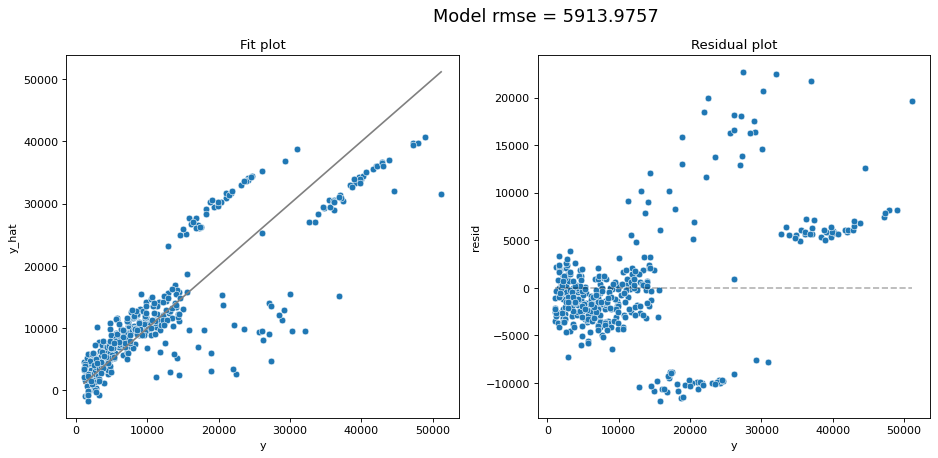

5913.975726628342

In [ ]:
model_fit(gs.best_estimator_, X_test_matrix, y_test, plot=True)

---

### 🚩 Exercise 13

How does this model compare to the performance of our baseline model? Is it better or worse?

The model performs better than the baseline model

---

### 🚩 Exercise 14

How do the model coefficient for this model compare to the base line model? Hint - be careful about which baseline model you compare with.

In [ ]:
get_coefs(gs.best_estimator_)

array([13627.95708162,  2086.35751417,  3497.47921814,   647.03866422,
         101.93257396,  9876.69773606])

They are very similar, compared to the scaled baseline model

To further explore this choice of  αα , we can collect relevant data about the folds and their performance from the cv_results_ attribute. In this case we are particularly interested in examining the mean_test_score and the split#_test_score keys since these are used to determine the optimal  αα .

In the code below we extract these data into a data frame by selecting our columns of interest along with the  αα  values used (and transform negative rmse values into positive values).

In [ ]:
cv_res = pd.DataFrame(
    data = gs.cv_results_
).filter(
    # Extract the split#_test_score and mean_test_score columns
    regex = '(split[0-9]+|mean)_test_score'
).assign(
    # Add the alphas as a column
    alpha = alphas
)

cv_res.update(
    # Convert negative rmses to positive
    -1 * cv_res.filter(regex = '_test_score')
)

This data frame can then be used to plot  αα  against the mean root mean squared value over the 5 folds, to produce the following plot.

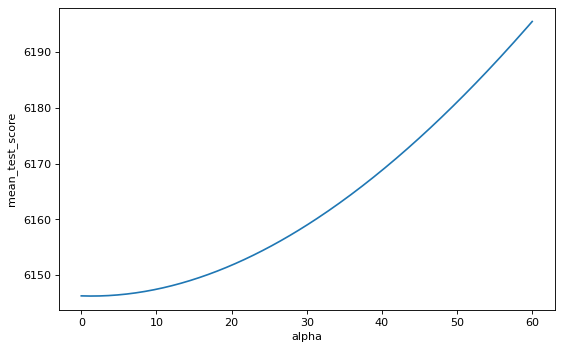

In [ ]:
sns.lineplot(x='alpha', y='mean_test_score', data=cv_res)
plt.show()

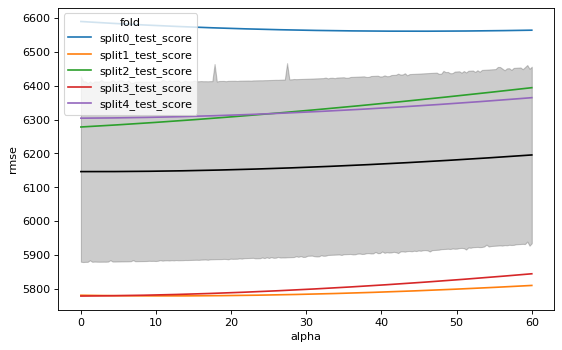

In [ ]:
d = cv_res.melt(
    id_vars=('alpha','mean_test_score'),
    var_name='fold',
    value_name='rmse'
)

sns.lineplot(x='alpha', y='rmse', color='black', data = d)  # Plot the mean rmse +/- the std dev of the rmse.
sns.lineplot(x='alpha', y='rmse', hue='fold', data = d) # Plot the curves for each fold
plt.show()

---

## 7. Competing the worksheet

At this point you have hopefully been able to complete all the preceeding exercises. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Once that is done and you are happy with everything, you can then generate your PDF and turn it in on gradescope under the `mlp-week05` assignment.